# Lab 11: Unsupervised learning
- **Author:** Emily Aiken ([emilyaiken@berkeley.edu](mailto:emilyaiken@berkeley.edu)), based on past labs by Guanghua Chi and Dmitrius Papadimitriou
- **Date:** April 13, 2022
- **Course:** INFO 251: Applied Machine Learning

## Topics:
1. K-means clustering
2. Principal components analysis with tabular data
2. Principal components analysis with image data

## Learning Goals:
At the end of this lab you will...
- Understand the k-means expectation maximization algorithm
- Know how to tune the number of clusters for k-means
- Know how to fit k-means and PCA with scikit-learn for tabluar and image data
- Know how to calculate explained variance and its relationship to the number of components for PCA 
- Understand how pre-processing with PCA can reduce overfitting in supervised learning settings

## Part 1: k-Means Clustering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, load_boston, load_digits
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score

#### A. Synthetic data

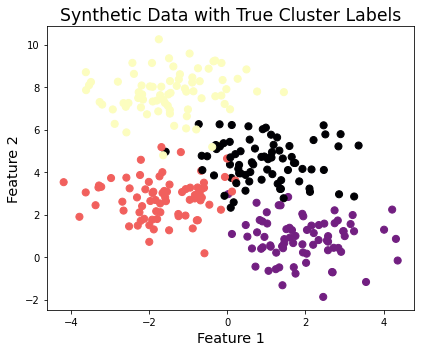

In [2]:
# Generate isotropic Gaussian blobs for clustering.
# See: http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html
x, y = make_blobs(n_samples=300, n_features=2, centers=4, cluster_std=1, random_state=0)

# Plot synthetic data
fig, ax = plt.subplots(1, figsize=(6, 5))
ax.scatter(x[:, 0], x[:, 1], c=y, s=50, cmap='magma')

# Clean up plot
ax.set_title('Synthetic Data with True Cluster Labels', fontsize='xx-large')
ax.set_xlabel('Feature 1', fontsize='x-large')
ax.set_ylabel('Feature 2', fontsize='x-large')
plt.tight_layout()
plt.show()

#### B. Scikit-learn implementation

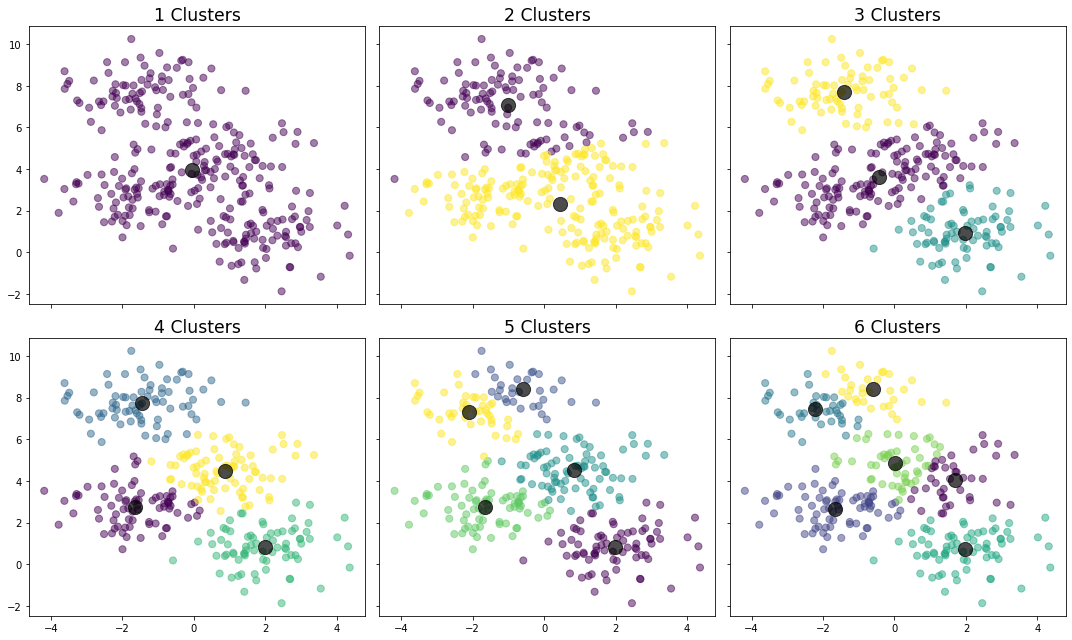

In [3]:
# Set up subplots
fig, ax = plt.subplots(2, 3, figsize=(15, 9), sharey=True, sharex=True)
ax=ax.flatten()

# Run k-means for different numbers of clusters
for n_clusters in range(1, 7):
    
    # Train and predict with k-means
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(x)
    yhat = kmeans.predict(x)
    
    # Plot data in subplot
    ax[n_clusters-1].scatter(x[:, 0], x[:, 1], c=yhat, s=50, cmap='viridis', alpha=0.5)
    
    # Get and plot cluster centers
    centers = kmeans.cluster_centers_
    ax[n_clusters-1].scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.7)
    
    # Clean up subplot
    ax[n_clusters-1].set_title('%i Clusters' % n_clusters, fontsize='xx-large')
    
# Clean up plot
plt.tight_layout()
plt.show()

#### C. How many clusters?

In [4]:
n_clusters = np.arange(1, 40)
sse = []
for n in n_clusters:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(x)
    sse.append(kmeans.inertia_)

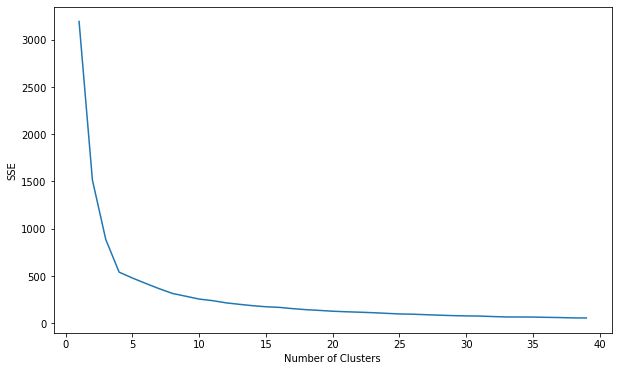

In [5]:
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.plot(n_clusters, sse)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('SSE')
plt.show()

## Part 2: Principal Component Analysis with Tabular Data

#### A. Load Boston Housing Prices data

In [6]:
# Load boston housing prices data
bdata = load_boston()
df = pd.DataFrame(bdata.data)
df.columns = bdata.feature_names[:]
df['target'] = bdata.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [7]:
# Standardize the data
for col in df.columns:
    if col != 'target':
        mean, std = df[col].mean(), df[col].std()
        df[col] = (df[col] - mean)/std

In [8]:
# Split data into training and test
train, test = train_test_split(df, shuffle=True, test_size=0.25, random_state=0)
x_train, y_train = train.drop('target', axis=1), train['target']
x_test, y_test = test.drop('target', axis=1), test['target']

#### B. Scikit-learn implementation

In [9]:
# Fit and "predict" (transform) with PCA
pca = PCA(n_components=5)
pca.fit(x_train)
embedding_train = pca.transform(x_train)
embedding_test = pca.transform(x_test)

In [10]:
# Get % of variance explained
print('Share of variation explained by each component: ', pca.explained_variance_ratio_)
print('Total variation explained: %.2f' % np.sum(pca.explained_variance_ratio_))

Share of variation explained by each component:  [0.4727527  0.10820677 0.09719971 0.06951724 0.06204705]
Total variation explained: 0.81


#### C. Number of components

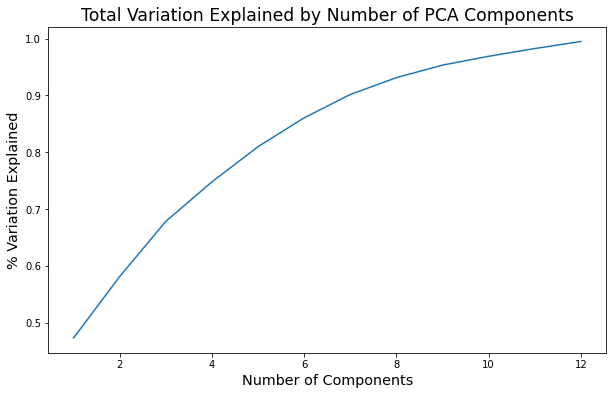

In [11]:
# Record variation explained based on number of components
variation_explained = []
n_components = range(1, len(x_train.columns))
for n in n_components:
    pca = PCA(n_components=n)
    pca.fit(x_train)
    variation_explained.append(np.sum(pca.explained_variance_ratio_))
    
# Plot
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.plot(n_components, variation_explained)
ax.set_title('Total Variation Explained by Number of PCA Components', fontsize='xx-large')
ax.set_xlabel('Number of Components', fontsize='x-large')
ax.set_ylabel('% Variation Explained', fontsize='x-large')
plt.show()

#### D. PCA and regression

In [12]:
# TODO: Try fitting PCAs of k components between 1 and 12 on the training data (pca.fit()). Then, project the 
# training and test data onto the k-dimensional subspace (pca.transform()). For each PCA transformation, fit an 
# OLS regression on the projected training features using scikit-learn's LinearRegression() class. Report the r2
# score for the regression on the training and test sets.

In [13]:
r2_train, r2_test = [], []
n_components = range(1, len(x_train.columns))
for n in n_components:
    
    # Fit PCA
    pca = PCA(n_components=n)
    pca.fit(x_train)
    
    # Project training and test X data
    x_train_projected = pca.transform(x_train)
    x_test_projected = pca.transform(x_test)
    
    # Fit linear regression
    model = LinearRegression()
    model.fit(x_train_projected, y_train)
    
    # Predict with linear regression
    yhat_train = model.predict(x_train_projected)
    yhat_test = model.predict(x_test_projected)
    
    # Calculate r2 scores
    r2_train.append(r2_score(y_train, yhat_train))
    r2_test.append(r2_score(y_test, yhat_test))

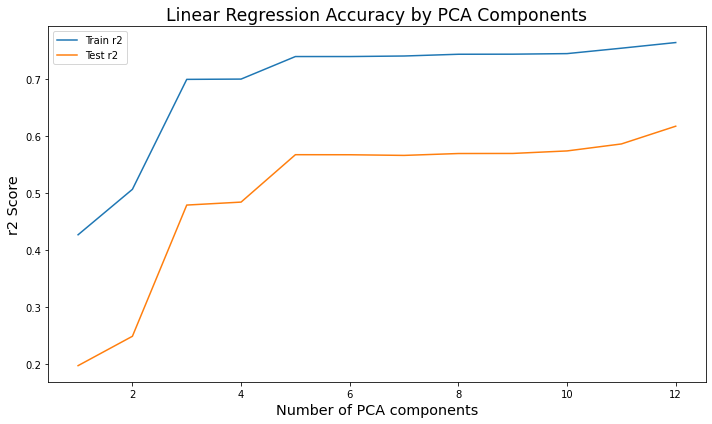

In [14]:
# Figure
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.plot(n_components, r2_train, label='Train r2')
ax.plot(n_components, r2_test, label='Test r2')
ax.set_title('Linear Regression Accuracy by PCA Components', fontsize='xx-large')
ax.set_xlabel('Number of PCA components', fontsize='x-large')
ax.set_ylabel('r2 Score', fontsize='x-large')
ax.legend(loc='best')
plt.tight_layout()
plt.show()

## Part 3: PCA with Image Data

#### A. Load MNIST data

In [15]:
# Load data
digits = load_digits()
x = digits.images
y = digits.target

# Standardize data
x = (x - np.mean(x, axis=0))/(np.std(x, axis=0) + 0.000000001)

# Flatten x data
x = x.reshape(x.shape[0], x.shape[1]*x.shape[2])

#### B. PCA to visualize latent relationships

In [16]:
# Fit and transform to 2 dimensions with PCA
pca = PCA(2)
projected = pca.fit_transform(x)

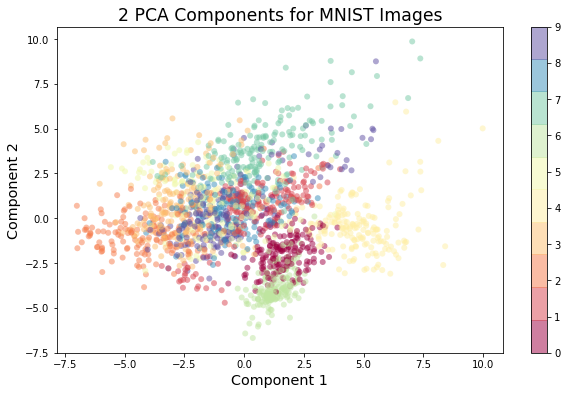

In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(projected[:, 0], projected[:, 1], c=y, cmap=plt.cm.get_cmap('Spectral', 10), edgecolor='none', 
            alpha=0.5)
plt.xlabel('Component 1', fontsize='x-large')
plt.ylabel('Component 2', fontsize='x-large')
plt.title('2 PCA Components for MNIST Images', fontsize='xx-large')

plt.colorbar()
plt.show()